# 台鐵車站的資料分析與視覺化 Part 4. 資料分析與視覺化

經過前面的處理，終於可以進入主題了！這些分析主題都是我自己看到資料得到的靈感，如果有更好的分析題目，都很歡迎交流！

首先先匯入套件跟資料

In [1]:
%config Completer.use_jedi = False
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns

如果要繪製含有中文字的圖表，需要另外指定字型。

In [2]:
import matplotlib as mpl
mpl.rc('font', family='Noto Sans CJK TC')

In [3]:
df_tr_count = pd.read_csv('train_count.csv', parse_dates=[0])
df_stapass_sim = pd.read_csv('station_passenger_simple_summary.csv', index_col=0)

In [4]:
df_tr_count = df_tr_count.set_index('trnOpDate')

## 1. 看資料說故事

藉由下圖，可以發現，運量似乎存在周期性變化？

<AxesSubplot:xlabel='trnOpDate', ylabel='Total'>

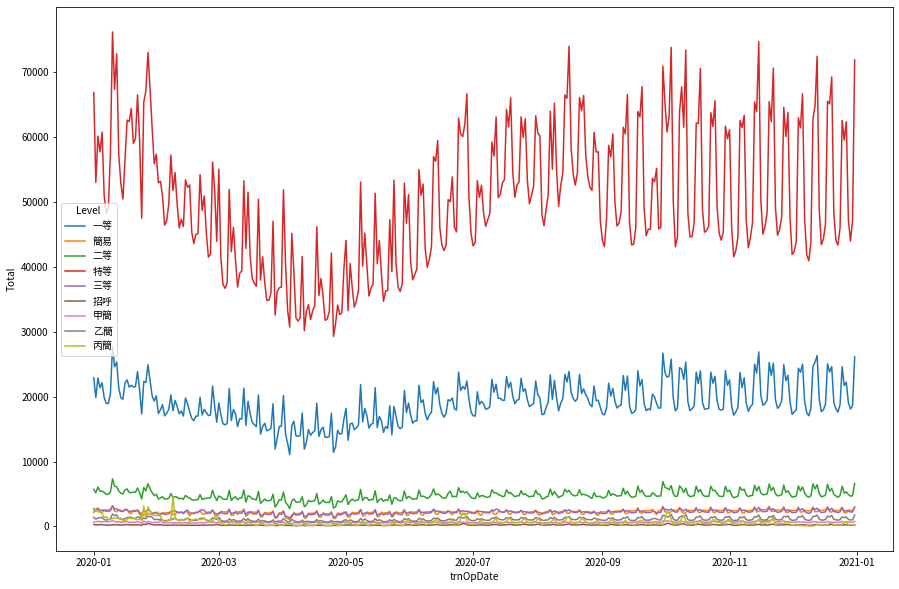

In [6]:
plt.figure(figsize=[15,10])
sns.lineplot(x=df_tr_count.index, y=df_tr_count.Total, hue=df_tr_count.Level, ci=None)

因為特等、一等、二等站較為明顯，如果我們只看那些等級較低的站...

<AxesSubplot:xlabel='trnOpDate', ylabel='Total'>

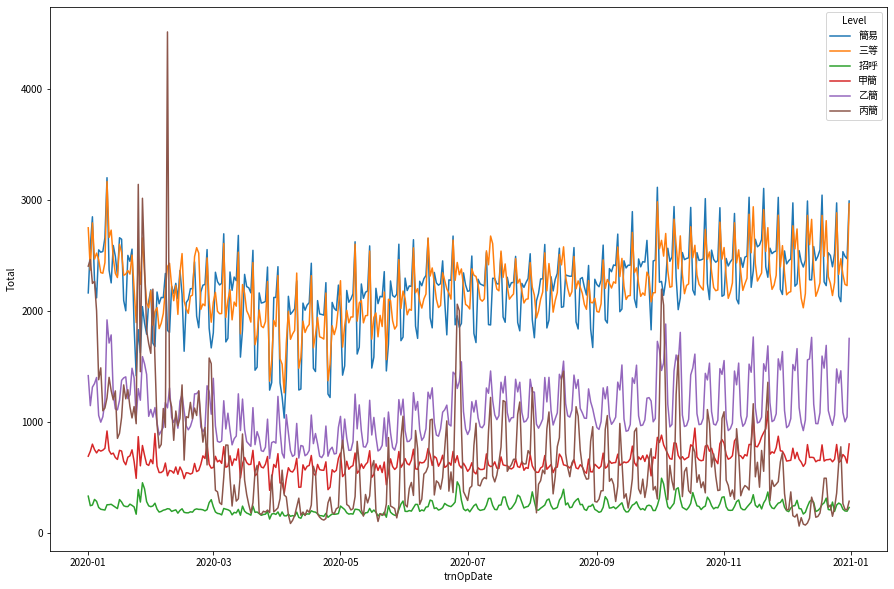

In [7]:
df_sel = df_tr_count[~df_tr_count.Level.isin(['特等', '一等', '二等'])]
plt.figure(figsize=[15,10])
sns.lineplot(x=df_sel.index, y=df_sel.Total, hue=df_sel.Level, ci=None)

會發現除了丙簡之外，其他等級的車站都有一定的pattern

如果研究一下，會發現丙簡只有兩個車站，我們可以單獨看看這兩個車站，會發現他們都在支線上

In [8]:
df_stapass_sim[df_stapass_sim.Level == '丙簡']

,stationCode,stationName,Level,Open,Line,max,min,mean,sum
93,3432,濁水,丙簡,1922-01-14,集集線,780,53,215.248634,78781
228,7332,十分,丙簡,1929-10-01,平溪線,8833,0,1115.781421,408376


如果去除掉丙簡，會發現每種類型的車站大概都有穩定的乘載量，然而簡易及三等的乘載量接近

<AxesSubplot:xlabel='trnOpDate', ylabel='Total'>

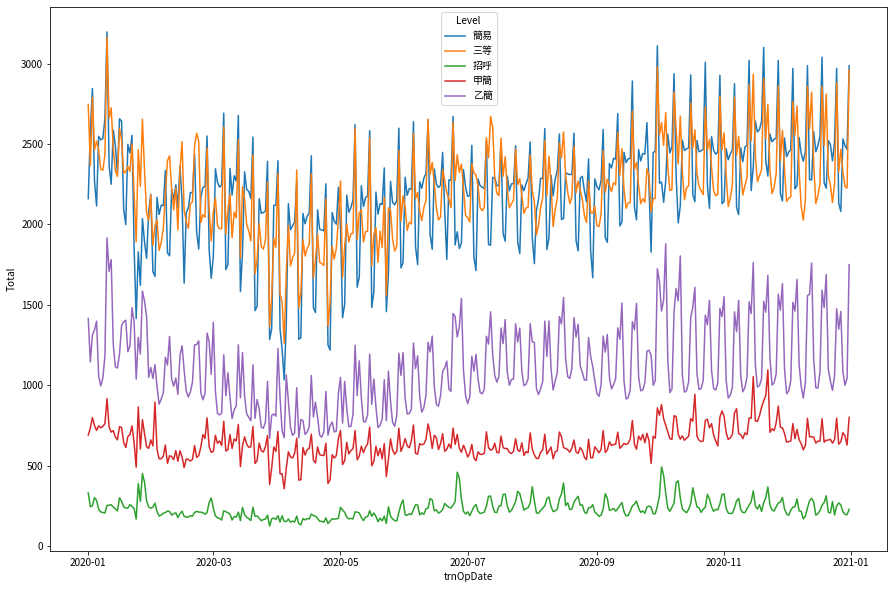

In [9]:
df_sel = df_tr_count[~df_tr_count.Level.isin(['特等', '一等', '二等', '丙簡'])]
plt.figure(figsize=[15,10])
sns.lineplot(x=df_sel.index, y=df_sel.Total, hue=df_sel.Level, ci=None)

丙簡是所有種類中，車站數量最少的

In [10]:
df_stapass_sim.groupby('Level').size()

Level
一等    28
三等    67
丙簡     2
乙簡    18
二等    25
招呼    40
特等     4
甲簡    12
簡易    43
dtype: int64

可以來看看這兩個車站的人數，會發現原來是十分的波動較大，看到這邊，我決定來研究一下十分所處的平溪線。

<AxesSubplot:xlabel='trnOpDate', ylabel='Total'>

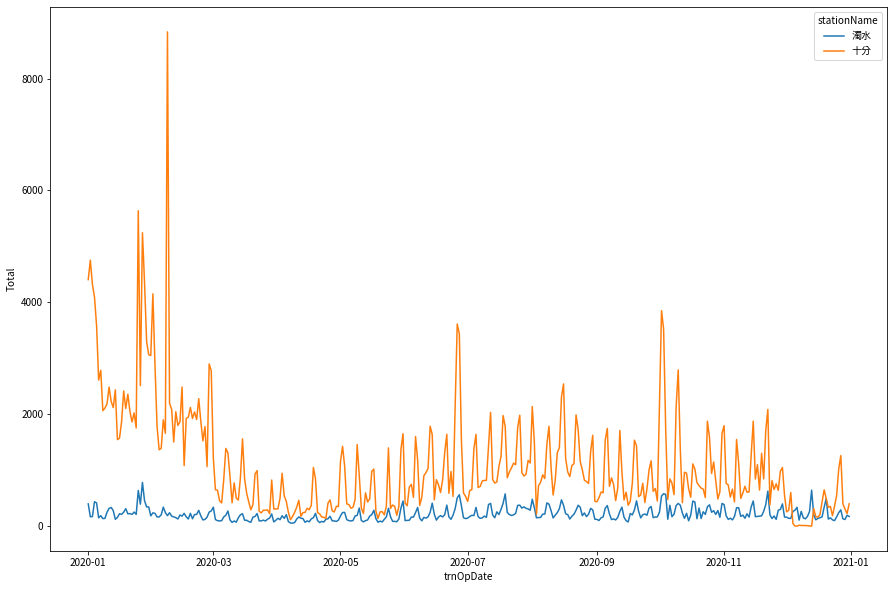

In [11]:
df_sel = df_tr_count[df_tr_count.stationName.isin(['濁水', '十分'])]
plt.figure(figsize=[15,10])
sns.lineplot(x=df_sel.index, y=df_sel.Total, hue=df_sel.stationName, ci=None)

### 平溪線

In [12]:
shifan = df_tr_count[df_tr_count.stationName == '十分']

In [13]:
shifan.iloc[shifan.Total.argmax(),:]

staCode            7332
gateInComingCnt    4308
gateOutGoingCnt    4525
Total              8833
stationName          十分
Level                丙簡
Name: 2020-02-08 00:00:00, dtype: object

可以發現2/8是最多人造訪的時候，如果上網搜尋這時間十分有什麼特別的活動的話，可以發現當天是平溪天燈節。

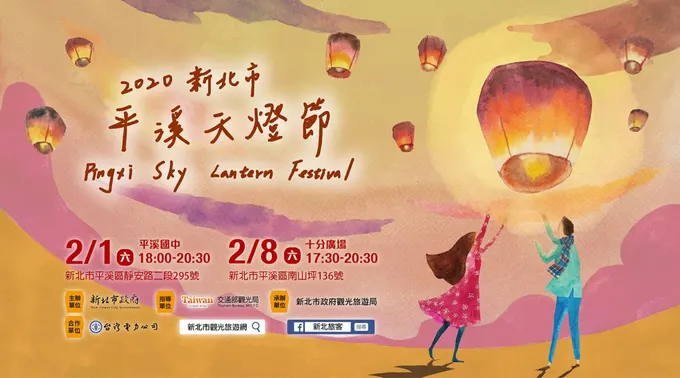

<AxesSubplot:xlabel='trnOpDate'>

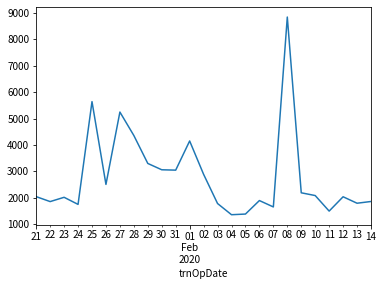

In [14]:
shifan[(shifan.index > '2020-01-20') & (shifan.index < '2020-02-15')].Total.plot()

我們已經知道2/8人之所以很多是因為天燈節，但如果再看一次圖表，會發現其實在天燈節就有高峰了，那這是怎麼回事呢？

如果畫一張比較局部的圖，會發現這個高峰出現在1/24-29附近，這個時間是農曆新年。因此不少人會選擇去十分走走。

In [15]:
shifan[shifan.index>'2020-06-15'].iloc[shifan[(shifan.index>'2020-06-15')& (shifan.index < '2020-08-15')].Total.argmax(),:]

staCode            7332
gateInComingCnt    1792
gateOutGoingCnt    1820
Total              3612
stationName          十分
Level                丙簡
Name: 2020-06-26 00:00:00, dtype: object

另外還可以在圖上看到兩個高峰，查一下會發現是6/26與10/2，分別是端午連假與中秋連假，可見十分算是連假時大家喜愛出遊的地點

回頭看看那張活動說明，會發現2/1還有一場在平溪國中，看地圖會發現平溪國中在平溪跟菁桐兩站之間，所以我們可以來看看2/1的人潮是否有增加

<AxesSubplot:xlabel='trnOpDate'>

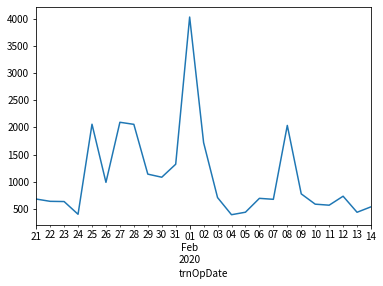

In [16]:
pingxi = df_tr_count[df_tr_count.stationName == '平溪']
pingxi[(pingxi.index > '2020-01-20') & (pingxi.index < '2020-02-15')].Total.plot()

果然那個高峰出現在2/1，2/8也有小高峰，不過不突出，我想可以當成是看去十分參加天燈節順道去了平溪？

<AxesSubplot:xlabel='trnOpDate'>

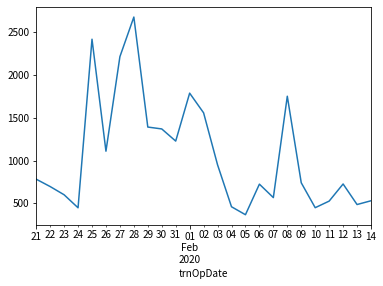

In [17]:
jingtong = df_tr_count[df_tr_count.stationName == '菁桐']
jingtong[(jingtong.index > '2020-01-20') & (jingtong.index < '2020-02-15')].Total.plot()

會發現雖然2/1菁桐也有小高峰，但仍不及過年時那麼高，甚至在2/8也有個高峰。我推測是因為平溪支線上所有的車站，大家通常會順道一起去，因此只要一個車站某個時間點有高峰，那同一條線上的車站也會受到影響。

至於為何2/1的活動沒有在菁桐有明顯的高峰，可能是因為從平溪過去會場還是比較方便一些，或者平溪的觀光能量還是比較強一些，大家直覺就會從平溪過去

In [18]:
px_line = df_stapass_sim[df_stapass_sim.Line.str.contains('平溪線')].stationName

<AxesSubplot:xlabel='trnOpDate', ylabel='Total'>

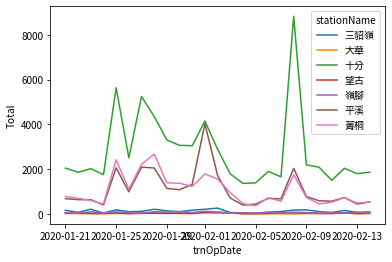

In [19]:
df_sel = df_tr_count[df_tr_count.stationName.isin(px_line)]
df_sel = df_sel[(df_sel.index > '2020-01-20') & (df_sel.index < '2020-02-15')]
sns.lineplot(x=df_sel.index, y=df_sel.Total, hue=df_sel.stationName, ci=None)

正如我所預期的，這些車站在這些時間確實都有類似的高峰

## 2. 車站人潮的週期性

每個車站的人潮似乎都存在一個周期性：兩個小高峰跟一個低谷，而且出現的時機相當一致，究竟這個規律是什麼？

In [20]:
df_sel = df_tr_count[df_tr_count.Level == '簡易']

<AxesSubplot:xlabel='trnOpDate'>

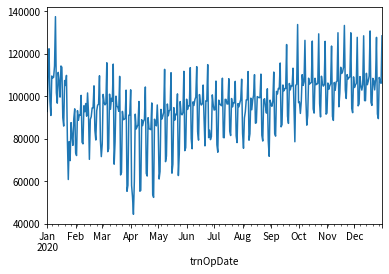

In [21]:
df_sel.groupby('trnOpDate').Total.sum().plot()

7月看起來沒有什麼太強的趨勢變化，只有周期性變化，比較能幫助我們不會受到趨勢干擾而影響解讀。

In [22]:
df_sel = df_tr_count[(df_tr_count.Level == '簡易') & (df_tr_count.index.month == 7)]

<AxesSubplot:xlabel='trnOpDate'>

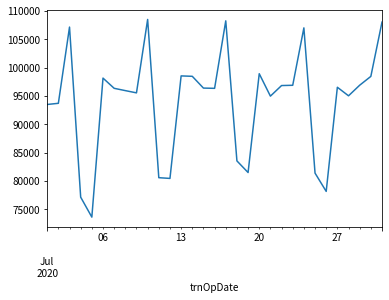

In [23]:
df_sel.groupby('trnOpDate').Total.sum().plot()

會發現低谷的位置剛好都差一個禮拜：5、12、19、26，而這些天剛好都是禮拜天，也可以看到次低點通常發生在禮拜六。最高點則是禮拜五。低點的位置大概可以解釋成是因為這些站的用途可能與工作較有關，因此非工作日時人潮較少。但禮拜五的高峰就比較難解釋了，看看各個車站的情況再來判斷如何解讀。

In [24]:
df_sel.stationName.unique()

array(['三坑', '百福', '五堵', '汐科', '浮洲', '南樹林', '北新竹', '千甲', '新莊', '三姓橋',
       '豐富', '泰安', '栗林', '頭家厝', '松竹', '精武', '五權', '大慶', '烏日', '大村', '水里',
       '嘉北', '水上', '柳營', '南科', '大橋', '仁德', '長榮大學', '左營', '內惟', '鼓山',
       '三塊厝', '民族', '科工館', '正義', '後庄', '竹田', '林榮新光', '豐田', '大溪', '牡丹',
       '平溪', '菁桐'], dtype=object)

<AxesSubplot:xlabel='trnOpDate'>

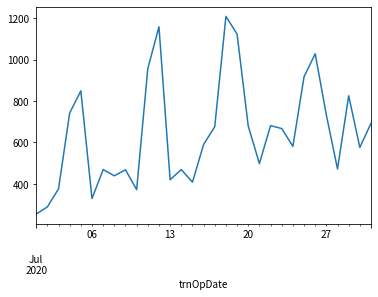

In [25]:
df_sel[df_sel.stationName == '平溪'].Total.plot()

<AxesSubplot:xlabel='trnOpDate'>

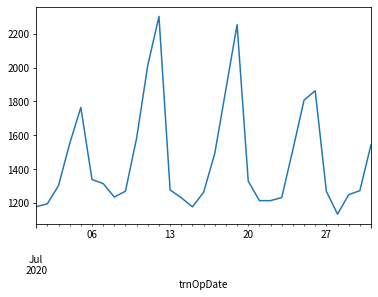

In [26]:
df_sel[df_sel.stationName == '烏日'].Total.plot()

<AxesSubplot:xlabel='trnOpDate'>

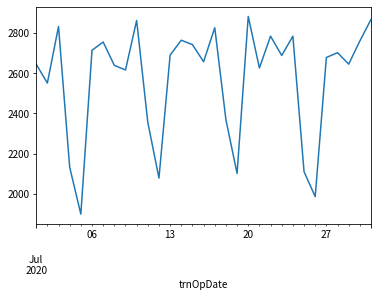

In [27]:
df_sel[df_sel.stationName == '三坑'].Total.plot()

如果仔細去看每個車站，會發現我原來的預期是錯的，事實上，每個車站都有自己的pattern，但週期大概都是1周。

例如三坑站比較符合各個車站總和後的周期pattern(也有周五的高峰)，但平溪跟烏日就不是這樣，是相反的(平日少，但越接近假日越多，並在禮拜天達到高峰)。

雖然車站有不同的pattern，但大致上，除了週期長度接近之外，兩者最大的不同是平日與假日的人潮，因此我決定從這邊下手，以假日及平日人潮做分割，來看看會得到什麼結論

In [28]:
df_m78 = df_tr_count[(df_tr_count.index.month == 8) | (df_tr_count.index.month == 7)]

In [324]:
df_m78.head()

,staCode,gateInComingCnt,gateOutGoingCnt,Total,stationName,Level,is_weekday
trnOpDate,,,,,,,
2020-07-01,900,6569,6051,12620,基隆,一等,True
2020-07-02,900,6456,6242,12698,基隆,一等,True
2020-07-03,900,7310,6973,14283,基隆,一等,True
2020-07-04,900,7359,7046,14405,基隆,一等,False
2020-07-05,900,6590,6376,12966,基隆,一等,False


In [30]:
weekday = pd.date_range('2020-07-01', '2020-08-31', freq='B')

In [31]:
df_m78['is_weekday'] = df_m78.index.isin(weekday)

<ipython-input-31-47589b86f421>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m78['is_weekday'] = df_m78.index.isin(weekday)


In [32]:
df_m78.head()

,staCode,gateInComingCnt,gateOutGoingCnt,Total,stationName,Level,is_weekday
trnOpDate,,,,,,,
2020-07-01,900,6569,6051,12620,基隆,一等,True
2020-07-02,900,6456,6242,12698,基隆,一等,True
2020-07-03,900,7310,6973,14283,基隆,一等,True
2020-07-04,900,7359,7046,14405,基隆,一等,False
2020-07-05,900,6590,6376,12966,基隆,一等,False


In [33]:
weekday_end = df_m78.groupby(['stationName', 'is_weekday']).Total.mean().reset_index()

In [34]:
weekday_end

,stationName,is_weekday,Total
0,七堵,False,8878.833333
1,七堵,True,12126.568182
2,三坑,False,2125.500000
3,三坑,True,2723.204545
4,三塊厝,False,629.111111
...,...,...,...
473,龍泉,True,30.522727
474,龍港,False,37.000000
475,龍港,True,33.818182
476,龜山,False,205.055556


將平日平均運量減去假日平均運量，看看結果。

In [35]:
weekday_end.Total.diff()

0               NaN
1       3247.734848
2     -10001.068182
3        597.704545
4      -2094.093434
           ...     
473       -7.643939
474        6.477273
475       -3.181818
476      171.237374
477      -23.123737
Name: Total, Length: 478, dtype: float64

In [36]:
weekday_more = weekday_end.Total.diff()[np.arange(1,478,2)]

In [37]:
week_ana = pd.DataFrame({'stationName': weekday_end.stationName.unique(), 'weekdayMore': weekday_more})\
            .reset_index(drop=True)

分別取出平日運量高的站名及假日運量高的站名。

In [38]:
wmore_station = week_ana[week_ana.weekdayMore>0].stationName
wless_station = week_ana[week_ana.weekdayMore<0].stationName

In [39]:
df_stapass_week = df_stapass_sim.copy()

In [40]:
df_stapass_week['wmore'] = df_stapass_sim.stationName.isin(wmore_station)

根據車站等級不同來作圖，看看不同等級的車站是否會有不同的平日、假日運量差異。

<AxesSubplot:xlabel='Level', ylabel='count'>

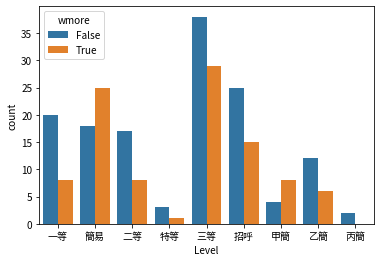

In [41]:
sns.countplot(x='Level', hue='wmore', data=df_stapass_week)

In [42]:
df_stapass_week[df_stapass_week.Level == '一等']

,stationCode,stationName,Level,Open,Line,max,min,mean,sum,wmore
0,900,基隆,一等,1891-10-20,縱貫線、基隆捷運（規劃中）,20685,6897,13492.571038,4938281,False
3,930,七堵,一等,1891-10-20,縱貫線,15654,5223,11144.581967,4078917,True
8,980,南港,一等,1899-07-20,臺灣鐵路縱貫線、北宜直線鐵路（規劃中）、基隆捷運（規劃中）、臺灣高鐵、板南線,29752,9400,21033.338798,7698202,True
9,990,松山,一等,1891-10-20,臺灣鐵路縱貫線、松山新店線、環狀線（規劃中）,41747,12679,29860.240437,10928848,True
11,1010,萬華,一等,1901-08-25,縱貫線,10371,3847,7955.464481,2911700,True
12,1020,板橋,一等,1901-08-25,臺灣鐵路縱貫線、臺灣高鐵、板南線（板橋線）、環狀線,90544,24591,41661.420765,15248080,False
14,1040,樹林,一等,1901-08-25,縱貫線,34217,15590,27085.942623,9913455,True
18,1080,桃園,一等,1893-10-30,縱貫線、綠線（興建中）、棕線（規劃中）,72977,27146,51193.002732,18736639,False
20,1100,中壢,一等,1893-10-30,縱貫線、機場線（興建中）,76976,26170,47975.188525,17558919,False
42,1210,新竹,一等,1893-10-30,縱貫線、內灣線,59883,21320,35863.770492,13126140,False


因為發現週期是以周為單位，且有平日、假日的差異，因此將車站人流區分為假日人潮較多的站與較少的站，前者可能是適合旅行、出遊的車站，後者可能比較偏向辦公、日常生活的車站，若仔細觀察各站，也可以發現這樣的推測似乎是合理的(但我不能保證這樣的推測是正確的，且我相信還有其他因素影響進出量)

## 3. 看看大家連假都去哪裡玩

我想要來看看在各個假期，大家最喜歡去哪裡玩呢？

接下來分析的結果，結論會建立在以下假設：
1. 大家前往該地主要透過火車
2. 人潮都是利用火車來運送的
3. 大多數人搭火車是為了出遊(當然我相信連假時，很多火車運量是為了服務返鄉的人，這個會影響我的分析結果，因此且戰且走吧)

另外我也來找幾個目標，來看看連假的出遊狀況
1. 春節(1/23-29)：7天
2. 228(2/28-3/1)：3天
3. 清明(4/2-5)：4天
4. 端午(6/25-28)：4天
5. 中秋(10/1-4)：4天
6. 國慶(10/9-11)：3天

為了簡化問題以及去除可能的共變因素，因此最後僅研究228及國慶連假。相較於其他假期，這兩個不屬於傳統節日，可能較可以將返鄉這個因子去除

在開始之前，需先找到baseline，看有哪些站高於自己的baseline，也許就代表大家都去那邊玩。或者拿假期前幾天當baseline來算，可能比較準。我決定使用假期前/後的一個禮拜來做baseline。

228的baseline:2/21-23

國慶的baseline:10/16-18

In [43]:
holi_221 = df_tr_count[(df_tr_count.index >= '2020-02-21') & (df_tr_count.index <= '2020-02-23')]
holi_228 = df_tr_count[(df_tr_count.index >= '2020-02-28') & (df_tr_count.index <= '2020-03-01')]
holi_1016 = df_tr_count[(df_tr_count.index >= '2020-10-16') & (df_tr_count.index <= '2020-10-18')]
holi_109 = df_tr_count[(df_tr_count.index >= '2020-10-09') & (df_tr_count.index <= '2020-10-11')]

In [44]:
holi_1016.head()

,staCode,gateInComingCnt,gateOutGoingCnt,Total,stationName,Level
trnOpDate,,,,,,
2020-10-16,900,8519,7953,16472,基隆,一等
2020-10-17,900,7527,7085,14612,基隆,一等
2020-10-18,900,7168,7099,14267,基隆,一等
2020-10-16,910,1449,1537,2986,三坑,簡易
2020-10-17,910,1072,1119,2191,三坑,簡易


In [45]:
holi_221_mean = holi_221.groupby('stationName').Total.mean().reset_index()
holi_228_mean = holi_228.groupby('stationName').Total.mean().reset_index()
holi_1016_mean = holi_1016.groupby('stationName').Total.mean().reset_index()
holi_109_mean = holi_109.groupby('stationName').Total.mean().reset_index()

In [46]:
holi_228_compare = holi_221_mean.merge(holi_228_mean, on='stationName', how='left')\
    .rename(columns={'Total_x':'Normal', 'Total_y':'Holiday'})
holi_109_compare = holi_1016_mean.merge(holi_109_mean, on='stationName', how='left')\
    .rename(columns={'Total_x':'Normal', 'Total_y':'Holiday'})

In [47]:
holi_228_compare['Holiday_ratio'] = holi_228_compare.Holiday/holi_228_compare.Normal
holi_109_compare['Holiday_ratio'] = holi_109_compare.Holiday/holi_109_compare.Normal
holi_228_compare['Holiday_diff'] = holi_228_compare.Holiday-holi_228_compare.Normal
holi_109_compare['Holiday_diff'] = holi_109_compare.Holiday-holi_109_compare.Normal

In [48]:
holi_228_compare[holi_228_compare.Holiday_ratio>1.5]

,stationName,Normal,Holiday,Holiday_ratio,Holiday_diff
4,三民,9.000000,21.333333,2.370370,12.333333
6,三貂嶺,237.000000,429.333333,1.811533,192.333333
24,內獅,0.666667,2.000000,3.000000,1.333333
58,外澳,149.000000,319.666667,2.145414,170.666667
70,大華,49.000000,84.333333,1.721088,35.333333
71,大里,332.000000,589.000000,1.774096,257.000000
77,富貴,21.000000,33.000000,1.571429,12.000000
83,崁頂,68.333333,110.666667,1.619512,42.333333
89,平溪,676.000000,1123.666667,1.662229,447.666667
95,志學,398.000000,1148.666667,2.886097,750.666667


觀察比例較高的幾個車站，內獅、枋山、三民之所以會高是因為base本來就很小，所以些微變動就導致比例急速上升。志學、長榮大學上網看了一下，可能是因為連假返鄉的關係(東華大學、長榮大學)，果然還是避不掉這個因子啊.......。

除此之外，看起來車埕和集集的人數上升比例較高，且此二車站的觀光十分興盛，因此應可推論228連假不少人去集集線遊玩，導致進出站人數暴增。但要注意的事情是，這邊看的是比例而非實際數值！

如果是看實際數值的話，則會發現花蓮是最多的，但可能有蠻大部分是返鄉？看起來這個差異也反映在車站的規模上，本來等級較高的站，似乎差異也會較大。

In [49]:
holi_228_compare.sort_values(by='Holiday_diff', ascending=False).head(10)

,stationName,Normal,Holiday,Holiday_ratio,Holiday_diff
197,花蓮,22029.666667,28486.000000,1.293074,6456.333333
194,臺南,45764.000000,49811.333333,1.088439,4047.333333
195,臺東,9659.666667,12779.666667,1.322993,3120.000000
103,新左營,19208.000000,22280.000000,1.159933,3072.000000
150,沙崙,3949.333333,5944.333333,1.505149,1995.000000
189,羅東,8598.000000,10303.000000,1.198302,1705.000000
52,嘉義,19172.333333,20813.333333,1.085592,1641.000000
152,泰安,2532.333333,4161.000000,1.643149,1628.666667
74,宜蘭,6615.666667,8028.333333,1.213534,1412.666667
98,斗六,11102.333333,12278.333333,1.105924,1176.000000


若是改看人數減少最多的車站，也會發現蠻有趣的現象！后里的人數直接減少將近88%，讓它與其他競爭者(?)拉開差距遙遙領先，同時也可以看到大部分的車站，尤其是前五名，皆是以日常生活通勤為主，我想也可以應證連假大家都會往其他地方跑的假設吧？

In [50]:
holi_228_compare.sort_values(by='Holiday_diff', ascending=True).head(10)

,stationName,Normal,Holiday,Holiday_ratio,Holiday_diff
46,后里,37278.000000,4677.333333,0.125472,-32600.666667
193,臺北,99209.000000,91069.666667,0.917958,-8139.333333
130,桃園,50168.666667,43879.333333,0.874636,-6289.333333
148,汐科,12854.000000,8011.666667,0.623282,-4842.333333
134,樹林,25230.666667,20443.000000,0.810244,-4787.666667
119,松山,25147.333333,20361.000000,0.809668,-4786.333333
207,豐原,20590.333333,16163.333333,0.784996,-4427.000000
8,中壢,47749.666667,44180.333333,0.925249,-3569.333333
191,臺中,56076.666667,52844.666667,0.942365,-3232.000000
72,太原,8329.333333,5459.666667,0.655475,-2869.666667


接著看國慶連假的部分，可以觀察到比例較高的車站與228時類似，除了是被base小的影響到之外，也可能代表大家連假出遊的樣態都差不多(無論哪個連假，大家會去的地方可能都一樣)，不過這次卻沒有志學跟長榮大學，似乎大家不會在國慶連假返鄉？不過有可能的原因是上禮拜為中秋連假，已經返鄉了，因此這禮拜就不會有這樣的現象。所以也許這更適合拿來代表民眾連假出遊的樣態？

除了車埕和集集仍然上榜外，許多熟悉的觀光車站也在榜上，如內灣、八斗子、十分、平溪、猴硐等。我認為這比228連假的數據更能代表哪些車站是連假熱門車站，當然也有可能實際上是不同的假期會讓人想去不一樣的景點(也就推翻了前面大家出遊樣態都差不多的假設)。

In [51]:
holi_109_compare[holi_109_compare.Holiday_ratio>1.5]

,stationName,Normal,Holiday,Holiday_ratio,Holiday_diff
6,三貂嶺,196.000000,448.333333,2.287415,252.333333
10,中里,1.000000,2.333333,2.333333,1.333333
23,內灣,1689.000000,2741.333333,1.623051,1052.333333
24,內獅,0.000000,5.333333,inf,5.333333
26,八斗子,365.666667,981.000000,2.682771,615.333333
30,加祿,23.000000,75.333333,3.275362,52.333333
34,十分,881.333333,2097.666667,2.380106,1216.333333
44,合興,363.333333,631.333333,1.737615,268.000000
59,大富,11.000000,18.666667,1.696970,7.666667
70,大華,29.666667,65.333333,2.202247,35.666667


In [52]:
holi_109_compare.sort_values(by='Holiday_diff', ascending=False).head(10)

,stationName,Normal,Holiday,Holiday_ratio,Holiday_diff
107,新竹,47581.000000,58445.666667,1.228340,10864.666667
191,臺中,67095.666667,73125.000000,1.089862,6029.333333
194,臺南,61965.000000,67961.000000,1.096764,5996.000000
197,花蓮,31605.000000,34384.333333,1.087940,2779.333333
121,板橋,48988.000000,51482.666667,1.050924,2494.666667
56,基隆,15117.000000,17569.000000,1.162201,2452.000000
171,瑞芳,7488.000000,9838.666667,1.313925,2350.666667
52,嘉義,24627.666667,26955.000000,1.094501,2327.333333
189,羅東,10304.666667,12517.666667,1.214757,2213.000000
8,中壢,60325.000000,62521.000000,1.036403,2196.000000


在這邊會發現排序出現了大變化，尤其是中壢，從原先的吊車尾到現在變成前段班。但是其上升幅度並不大，因為base較大。

至於倒數的名次，仍以工作通勤車站為主，而台北站則不在前10名。讓我們來看看台北站這次的表現。

In [53]:
holi_109_compare.sort_values(by='Holiday_diff', ascending=True).head(10)

,stationName,Normal,Holiday,Holiday_ratio,Holiday_diff
148,汐科,14928.000000,10002.000000,0.670016,-4926.000000
119,松山,28539.000000,25325.000000,0.887382,-3214.000000
147,汐止,19075.333333,16280.000000,0.853458,-2795.333333
21,內壢,18937.333333,16552.000000,0.874041,-2385.333333
184,竹北,12091.000000,9985.666667,0.825876,-2105.333333
40,南港,21530.333333,19499.666667,0.905683,-2030.666667
64,大橋,7651.000000,6271.000000,0.819631,-1380.000000
50,善化,8213.000000,6863.666667,0.835708,-1349.333333
106,新營,12094.000000,10782.333333,0.891544,-1311.666667
0,七堵,10719.000000,9457.666667,0.882327,-1261.333333


In [54]:
holi_109_compare[holi_109_compare.stationName == '臺北']

,stationName,Normal,Holiday,Holiday_ratio,Holiday_diff
193,臺北,125066.0,125359.333333,1.002345,293.333333


人數有微幅上升，但差異不大。從這裡可以看到，雖然兩個連假有些共同點，但實際上，不少車站的進出人數有極大的變化，如中壢從原先的大幅減少變成了增加，臺北也從大幅減少變為持平。因此我推測大家連假出去玩的樣態是會隨著連假不同而有所改變，但究竟何者是改變因子？日期？氣候？前後有無連假？返鄉需求？這些都可以再深入討論，但並不在這個專案的呈現範圍內，留待以後再探討。

## 4. 資料視覺化

最後一步則是將資料用好的方式呈現，這邊我選擇結合地圖，將各車站基本資料與年運量呈現出來。成果如下：

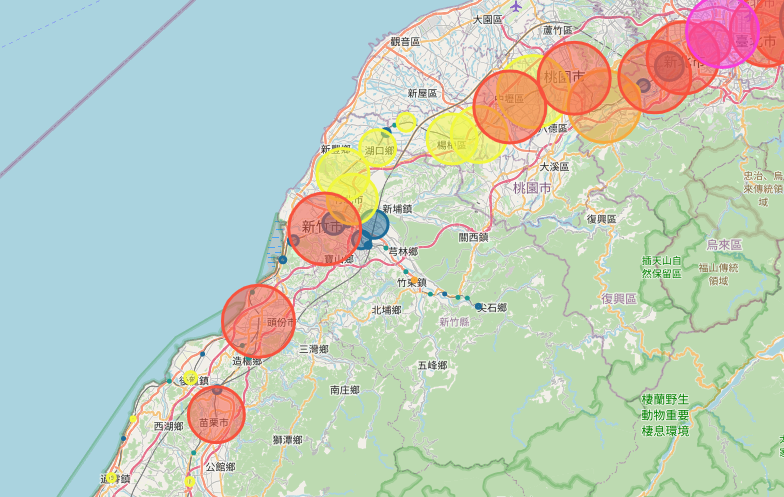

我希望不同等級的車站可以用不同顏色代表，且車站會根據年運量有不同的大小。有了這樣的想法後，再來就是實作了！

In [209]:
import folium
import json

In [304]:
from bokeh.plotting import figure, show
from bokeh.layouts import row as bokeh_row
from bokeh.models import Div
from bokeh.embed import file_html
from bokeh.resources import INLINE

要用地圖，就必須有GPS相關資料，之前就已經有蒐集到了，現在拿出來用~

In [76]:
df_station = pd.read_csv('df_station.csv', index_col=0)

In [153]:
df_station_withgps = df_stapass_sim.merge(df_station[['stationCode', 'gps']], on='stationCode', how='left')

In [154]:
df_station_withgps.gps = df_station_withgps.gps.str.split(' ')

In [155]:
df_station_withgps['Lat'] = df_station_withgps.gps.apply(lambda x: x[0])
df_station_withgps['Long'] = df_station_withgps.gps.apply(lambda x: x[1])

In [156]:
df_station_withgps.drop('gps', axis=1, inplace=True)

整理後，資料長這樣。我將會用這張表來製作接下來的視覺化部分。

In [157]:
df_station_withgps.head()

,stationCode,stationName,Level,Open,Line,max,min,mean,sum,Lat,Long
0,900,基隆,一等,1891-10-20,縱貫線、基隆捷運（規劃中）,20685,6897,13492.571038,4938281,25.13401,121.74013
1,910,三坑,簡易,2003-05-09,縱貫線,3202,1417,2522.655738,923292,25.12305,121.74202
2,920,八堵,二等,1899-07-20,縱貫線、宜蘭線,5952,2152,4175.448087,1528214,25.10843,121.72898
3,930,七堵,一等,1891-10-20,縱貫線,15654,5223,11144.581967,4078917,25.09294,121.71415
4,940,百福,簡易,2007-05-08,縱貫線,6675,2344,4857.756831,1777939,25.07803,121.69373


首先要將不同等級的車站標上顏色，在這邊我針對不同等級的車站給予不同色碼。

In [158]:
df_station_withgps['color'] = df_station_withgps['Level']

In [160]:
df_station_withgps.color.replace({'招呼':'#1d9991',
                                  '丙簡':'#1d6c99',
                                  '乙簡':'#1d6c99',
                                  '甲簡':'#1d6c99',
                                  '簡易':'#1d6c99',
                                  '三等':'#f1f73e',
                                  '二等':'#f7aa3e',
                                  '一等':'#f7533e',
                                  '特等':'#f73ed8'}, inplace=True)

同時我希望可以讓畫面更有邏輯性，我希望等級之間是有順序的，因此要轉換資料型態(其實早該轉了，只是之前用不到就想說算了)

In [162]:
df_station_withgps.Level.dtypes

dtype('O')

In [163]:
level_dtype = pd.CategoricalDtype(['招呼','丙簡','乙簡','甲簡','簡易','三等','二等','一等','特等'], ordered=True)

In [164]:
level_dtype

CategoricalDtype(categories=['招呼', '丙簡', '乙簡', '甲簡', '簡易', '三等', '二等', '一等', '特等'], ordered=True)

In [165]:
df_station_withgps.Level = df_station_withgps.Level.astype(level_dtype)

資料整理完後，便可以開始製圖了。過程就不細講，簡單來說就是先產生一張地圖，然後一一放上需要的元素這樣。

In [322]:
center_pos = [23.5, 121.0]
m_sim = folium.Map(location=center_pos, zoom_start=7.5)

for grp_name, df_grp in df_station_withgps.groupby('Level'):
    feature_group = folium.FeatureGroup(grp_name)
    for _, row in df_grp.iterrows():
        html = '''<h3><b>{}</b></h3><br><ul><li>{}站<li>啟用於{}<li>途經{}<li>2020年進出站人次{}人</ul>'''\
            .format(row['stationName'], row['Level'], row['Open'], row['Line'], row['sum'])
        iframe = folium.IFrame(html, width=350, height=220)
        
        folium.Circle(location=[row['Lat'], row['Long']],
                             color=row['color'],
                             radius=np.maximum(np.minimum(row['sum']/1000, 5000), 100),
                             popup=folium.Popup(iframe),
                             fill=True,
                             fill_opacity=0.5).add_to(feature_group)
    feature_group.add_to(m_sim)

folium.LayerControl().add_to(m_sim)


m_sim

我還有做一個更進階的版本，不僅呈現上述資訊，還有每日運量的圖表。然而因為資訊量過大(我只會做靜態網頁......)，所以執行需要一段時間，產出的html檔也有幾百MB，覺得要改成動態網頁的做法會比較好，就留待以後再來研究了。

In [ ]:
center_pos = [23.5, 121.0]
m = folium.Map(location=center_pos, zoom_start=7.5)

for grp_name, df_grp in df_station_withgps.groupby('Level'):
    feature_group = folium.FeatureGroup(grp_name)
    for _, row in df_grp.iterrows():
        
        df_temp = df_tr_count[df_tr_count.stationName==row['stationName']]
        
        f1 = Div(text='''<h1><b>{}</b></h1><br><ul><li>{}站<li>啟用於{}<li>途經{}<li>2020年進出站人次{}人</ul>'''\
            .format(row['stationName'], row['Level'], row['Open'], row['Line'], row['sum']))
        
        f2 = figure(title="Station", x_axis_label='Date', y_axis_label='Total', x_axis_type="datetime",
                    plot_width=500, plot_height=300)
        f2.line(x=df_temp.index, y=df_temp.Total, line_width=2)
        
        p = bokeh_row(f1, f2)
        
        html = file_html(p, INLINE, 'my_plot')
        iframe = folium.IFrame(html, width=750, height=350)
        
        folium.Circle(location=[row['Lat'], row['Long']],
                             color=row['color'],
                             radius=np.minimum(row['sum']/1000, 5000),
                             popup=folium.Popup(iframe),
                             fill=True,
                             fill_opacity=0.5).add_to(feature_group)
    feature_group.add_to(m)

folium.LayerControl().add_to(m)


m

In [323]:
m_sim.save('train_station_simplified.html')